## 1. Adding imports & installing neccessay packages ##

In [30]:
!pip -q install transformers

In [31]:
### run this if using google colab to mount google drive as local storage

from google.colab import drive
import os
drive.mount('/content/gdrive')

repo_path = '/content/gdrive/MyDrive/colab/NLP-Bootcamp/'

Mounted at /content/gdrive


In [32]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

import tensorflow as tf
import pandas as pd
import numpy as np
import collections
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

## 2. Loading Data ##

In [33]:
### run below 2 lines of code for setting train & test data path on google colab
trainData = os.path.join(repo_path, 'data/sentiment140_160k_tweets_train.csv')
testData = os.path.join(repo_path, 'data/sentiment140_test.csv')

### run below 3 lines of code for setting train & test data path on local machine
'''
DATA = './data/'
trainData = DATA + 'sentiment140_160k_tweets_train.csv'
testData =  DATA + 'sentiment140_test.csv'
'''

train = pd.read_csv(trainData)
test = pd.read_csv(testData)

train.head()

,target,ids,user,text
0,p,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ..."
1,p,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...
2,p,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...
3,p,1753662211,lovemandy,"had a good day driving up mountains, visiting ..."
4,p,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.


Looking at distribution of *'positives'* & *'negatives'* samples in train dataset

In [34]:
collections.Counter(train['target'])

Counter({'p': 80000, 'n': 79985})

<Axes: xlabel='target'>

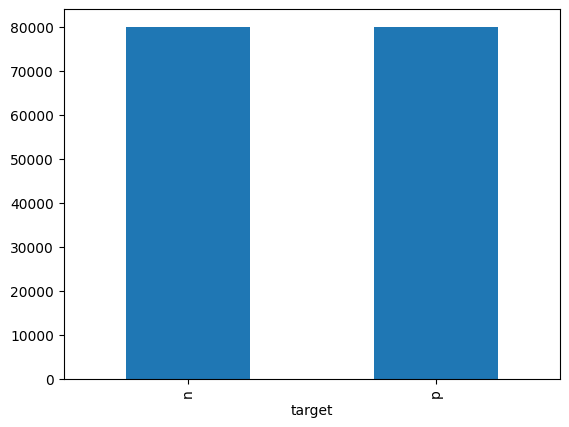

In [35]:
train.groupby('target').size().plot(kind='bar')

We will find that it is a relatively well-balanced dataset

array([[<Axes: title={'center': 'length'}>]], dtype=object)

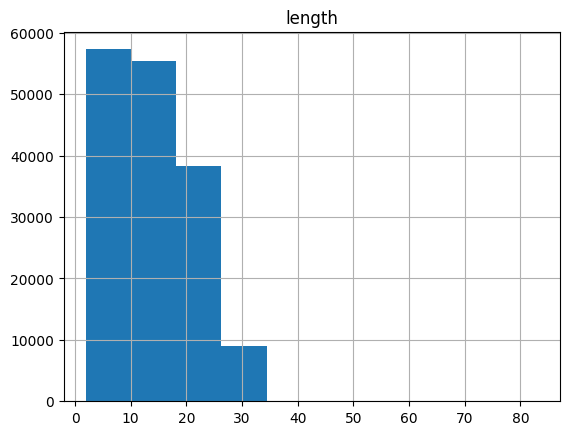

In [36]:
# review text length of training data
# BERT max is 512
train['length'] = train['text'].apply(lambda x: len(x.split(' ')))

train.hist("length", bins=10)

## 3. Data (Text) Preprocessing ##

In [37]:
x_train, x_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size = 0.2, shuffle = True)

In [38]:
# Which model to use?
model_name = 'bert-base-cased' # can handle upper & lower case

# Load a tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2) # num_labels = how many class

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
train_texts = x_train.tolist()
valid_texts = x_test.tolist()

print(len(train_texts))
train_texts[:5]

127988


['@noooaahsark thanks, for making me feel stupid ',
 "@soulwax Do you know which brand the tees are? I'd like to know before I order to make sure what size I need... ",
 'Right school tomorrow  so off to sleep! Night all! X',
 '@MattPalmerMusic yes Matt! Get it! ',
 'Its called a breakdown. Its not fun &gt;.&gt; ']

## 4. Sentiment Analysis using Deep Learning-based Method: RNN ##

In [40]:
# Pad the tokenizer outputs to the same length for all samples

# tokenize the training data
train_tokens = tokenizer(train_texts,
                         max_length = 64, #max tokenizer
                         truncation = True, #truncate if above 128 tokens
                         padding = 'max_length', #if less than 128 tokens fill to 128
                         add_special_tokens = True,
                         return_token_type_ids = False,
                         return_tensors = 'tf') #pt for pytorch

# tokenize the validation data
valid_tokens = tokenizer(valid_texts,
                         max_length = 64, #max tokenizer
                         truncation = True, #truncate if above 128 tokens
                         padding = 'max_length',
                         add_special_tokens = True,
                         return_token_type_ids = False,
                         return_tensors = 'tf')


In [41]:
train_tokens['input_ids'][0]

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([  101,   137,  1185,  5658, 22118,  9524, 23822,  5438,   117,
        1111,  1543,  1143,  1631,  4736,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)>

In [42]:
# map the labels
label_map = {'p':1, 'n':0} # for one hot encoding later (start from 0)
label_map

# Map the labels to our dictionary
train_labels = y_train.map(label_map).values
valid_labels = y_test.map(label_map).values

In [43]:
# verifying labels mapping

row = 400

y_train.iloc[row], train_labels[row]

('p', 1)

In [44]:
# optimizer
opt = tf.keras.optimizers.Adam(learning_rate = 5e-5, epsilon = 1e-8) # BERT needs a very low learning rate
# can use AdamW as well

#loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # use to do softmax as BERT final model is not softmax

# compile the model
model.compile(optimizer = opt,
              loss = loss,
              metrics = ['accuracy'])
# BLEU score for translation tasks

In [45]:
# lets look at the model
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# let's freeze the bert layer & train only the last layer
model.layers[0].trainable = False

model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 1538 (6.01 KB)
Non-trainable params: 108310272 (413.17 MB)
_________________________________________________________________


In [47]:
# train the model
model.fit(dict(train_tokens), train_labels,
          epochs = 5,
          batch_size = 16, # don't use large batch size for BERT
          validation_data=(dict(valid_tokens), valid_labels),
          verbose = 1)

Epoch 1/3
 756/8000 [=>............................] - ETA: 26:22 - loss: 0.4675 - accuracy: 0.7811

KeyboardInterrupt: 